In [ ]:
import re
import gzip
import nltk
import string
import gensim
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf 
import contractions as contr
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words=stopwords.words('english')
from termcolor import colored

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


#Data Preprocessing Libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential


#model evaluation libaries
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

In [ ]:
#Reading the JSON files and converting to Dataframe 
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [ ]:
beauty_df= getDF('/content/MyDrive/MyDrive/Datasets/reviews_Beauty_5.json.gz')

In [ ]:
grocery_df= getDF('/content/MyDrive/MyDrive/Datasets/reviews_Grocery_and_Gourmet_Food_5.json.gz')

In [ ]:
phone_df= getDF('/content/MyDrive/MyDrive/Datasets/reviews_Cell_Phones_and_Accessories_5.json.gz')

In [ ]:
music_df=getDF('/content/MyDrive/MyDrive/Datasets/reviews_Musical_Instruments_5.json.gz')

In [ ]:
office_df=getDF('/content/MyDrive/MyDrive/Datasets/reviews_Office_Products_5.json.gz')

In [ ]:
lawn_df=getDF('/content/MyDrive/MyDrive/Datasets/reviews_Patio_Lawn_and_Garden_5.json.gz')

In [ ]:
toys_df=getDF('/content/MyDrive/MyDrive/Datasets/reviews_Toys_and_Games_5.json.gz')

In [ ]:
pet_df=getDF('/content/MyDrive/MyDrive/Datasets/reviews_Pet_Supplies_5.json.gz')

In [ ]:
beauty_df.drop(['reviewerID','asin','reviewerName','helpful','unixReviewTime','reviewTime','summary'],inplace=True,axis=1)
grocery_df.drop(['reviewerID','asin','reviewerName','helpful','unixReviewTime','reviewTime','summary'],inplace=True,axis=1)
phone_df.drop(['reviewerID','asin','reviewerName','helpful','unixReviewTime','reviewTime','summary'],inplace=True,axis=1)
music_df.drop(['reviewerID','asin','reviewerName','helpful','unixReviewTime','reviewTime','summary'],inplace=True,axis=1)
office_df.drop(['reviewerID','asin','reviewerName','helpful','unixReviewTime','reviewTime','summary'],inplace=True,axis=1)
lawn_df.drop(['reviewerID','asin','reviewerName','helpful','unixReviewTime','reviewTime','summary'],inplace=True,axis=1)
toys_df.drop(['reviewerID','asin','reviewerName','helpful','unixReviewTime','reviewTime','summary'],inplace=True,axis=1)
pet_df.drop(['reviewerID','asin','reviewerName','helpful','unixReviewTime','reviewTime','summary'],inplace=True,axis=1)


###### Category assignment 

In [ ]:
beauty_df['category']= 'beauty'
grocery_df['category']= 'grocery'
phone_df['category']= 'phone'
music_df['category']= 'music'
office_df['category']= 'office'
lawn_df['category']= 'lawn'
toys_df['category']= 'toy'
pet_df['category']= 'pet'


### concat all the  categories

In [ ]:
master_data= pd.concat([beauty_df,grocery_df,phone_df,music_df,office_df,lawn_df,toys_df,pet_df])

In [ ]:
master_data['category'].value_counts()

beauty     198502
phone      194439
toy        167597
pet        157836
grocery    151254
office      53258
lawn        13272
music       10261
Name: category, dtype: int64

In [ ]:
print(colored('Total lenght of data',"red"),colored(len(master_data),'green'))

Total lenght of data 946419


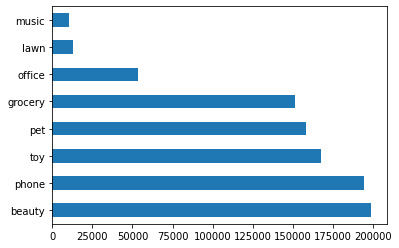

In [ ]:
master_data['category'].value_counts().plot(kind='barh')

In [ ]:
master_data.drop_duplicates(inplace=True)

In [ ]:
len(master_data)

945792

In [ ]:
master_data.dropna(inplace=True)

In [ ]:
len(master_data)

945792

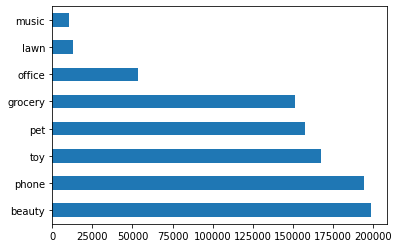

In [ ]:
master_data['category'].value_counts().plot(kind='barh')

In [ ]:
master_data.head(10)

,reviewText,overall,category
0,Very oily and creamy. Not at all what I expect...,1.0,beauty
1,This palette was a decent price and I was look...,3.0,beauty
2,The texture of this concealer pallet is fantas...,4.0,beauty
3,I really can't tell what exactly this thing is...,2.0,beauty
4,"It was a little smaller than I expected, but t...",3.0,beauty
5,"I was very happy to get this palette, now I wi...",5.0,beauty
6,PLEASE DONT DO IT! this just rachett the palet...,1.0,beauty
7,"Chalky,Not Pigmented,Wears off easily,Not a Co...",2.0,beauty
8,Did nothing for me. Stings when I put it on. I...,2.0,beauty
9,I bought this product to get rid of the dark s...,3.0,beauty


# Data Cleaning 

In [ ]:
def clean(text):
  text= text.lower()
  text=re.sub(r'http:\S+',' ',text,flags=re.MULTILINE)
  text=contr.fix(text)
  text=re.sub('[^A-Za-z]',' ',text)
  text=re.sub(r'\.+',' ',text)
  tokens=word_tokenize(text)
  text= [word for word in tokens if word not in stop_words]
  text=[word for word in text if word not in string.punctuation]
  return ' '.join(text)

  

In [ ]:
master_data['cleaned_text'] = master_data['reviewText'].apply(lambda x: clean(x))

In [ ]:
master_data.head(2)

,reviewText,overall,category,cleaned_text
0,Very oily and creamy. Not at all what I expect...,1.0,beauty,oily creamy expected ordered try highlight con...
1,This palette was a decent price and I was look...,3.0,beauty,palette decent price looking different shades ...


In [ ]:
category_label={'beauty':0,'grocery':1,'phone':2,'music':3,'office':4,'lawn':5,'toy':6,'pet':7}
master_data['label'] = master_data['category'].map(category_label)

In [ ]:
master_data.head()

,reviewText,overall,category,cleaned_text,label
0,Very oily and creamy. Not at all what I expect...,1.0,beauty,oily creamy expected ordered try highlight con...,0
1,This palette was a decent price and I was look...,3.0,beauty,palette decent price looking different shades ...,0
2,The texture of this concealer pallet is fantas...,4.0,beauty,texture concealer pallet fantastic great cover...,0
3,I really can't tell what exactly this thing is...,2.0,beauty,really tell exactly thing powder kind oil ish ...,0
4,"It was a little smaller than I expected, but t...",3.0,beauty,little smaller expected okay lasted long time ...,0


In [ ]:
data= master_data[['cleaned_text','label']]

In [ ]:
data.head()

,cleaned_text,label
0,oily creamy expected ordered try highlight con...,0
1,palette decent price looking different shades ...,0
2,texture concealer pallet fantastic great cover...,0
3,really tell exactly thing powder kind oil ish ...,0
4,little smaller expected okay lasted long time ...,0


In [ ]:
data['label'].dtype

dtype('int64')

In [ ]:
data['cleaned_text_len'] = data['cleaned_text'].apply(lambda x: len(x.split()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
max(data['cleaned_text_len'])

3090

In [ ]:
min(data['cleaned_text_len'])

0

In [ ]:
len(data[data['cleaned_text_len']==600])

7

In [ ]:
data.iloc[8000]

cleaned_text        made hair super soft smells really good actual...
label                                                               0
cleaned_text_len                                                   13
Name: 8001, dtype: object

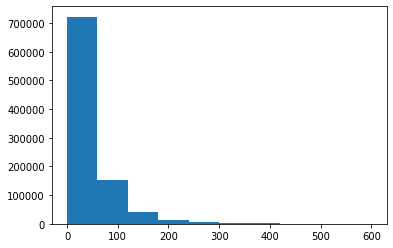

In [ ]:
plt.hist(data['cleaned_text_len'],range=(0,600));

In [ ]:
#Dropping the rows which have no words after cleaning
drop_list_0=data[data['cleaned_text_len']==0].index
drop_list_1=data[data['cleaned_text_len']==1].index
drop_list= drop_list_0.append(drop_list_1)
drop_list

Int64Index([   114,   2042,   9673,  22703,  36314,  93640, 138544, 157259,
            196005,   3530,
            ...
            140840, 141651, 141697, 142673, 147936, 148218, 152572, 154060,
            154886, 157745],
           dtype='int64', length=676)

In [ ]:
len(drop_list)

676

In [ ]:
data.drop(index=drop_list,inplace=True,errors='raise')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


###### Splitting the data and shuffle it 

In [ ]:
#Training Samples
train_class_0= data[data['label']==0][0:9000]
train_class_1= data[data['label']==1][0:9000]
train_class_2= data[data['label']==2][0:9000]
train_class_3= data[data['label']==3][0:9000]
train_class_4= data[data['label']==4][0:9000]
train_class_5= data[data['label']==5][0:9000]
train_class_6= data[data['label']==6][0:9000]
train_class_7= data[data['label']==7][0:9000]

#Testing Samples
test_class_0= data[data['label']==0][9000:10000]
test_class_1= data[data['label']==1][9000:10000]
test_class_2= data[data['label']==2][9000:10000]
test_class_3= data[data['label']==3][9000:10000]
test_class_4= data[data['label']==4][9000:10000]
test_class_5= data[data['label']==5][9000:10000]
test_class_6= data[data['label']==6][9000:10000]
test_class_7= data[data['label']==7][9000:10000]


In [ ]:
train_sample= pd.concat([train_class_0,train_class_1,train_class_2,train_class_3,train_class_4,train_class_5,train_class_6,train_class_7])

In [ ]:
len(train_sample)

72000

In [ ]:
train=train_sample.sample(frac=1)

In [ ]:
test_sample= pd.concat([test_class_0,test_class_1,test_class_2,test_class_3,test_class_4,test_class_5,test_class_6,test_class_7])

In [ ]:
len(test_sample)

8000

In [ ]:
test=test_sample.sample(frac=1)

In [ ]:
X_train=np.array(train['cleaned_text'])
y_train=np.array(train['label'])
X_test=np.array(test['cleaned_text'])
y_test=np.array(test['label'])

In [ ]:
# X_train,X_test,y_train,y_test= train_test_split(data['cleaned_text'],data['label'],random_state=60,test_size=0.2)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(72000,)
(8000,)
(72000,)
(8000,)


# Data Preprocessing 

In [ ]:
tokenizer= Tokenizer(oov_token='<UNK>')
tokenizer.fit_on_texts(X_train)
word_index=tokenizer.word_index

In [ ]:
len(word_index)

61192

In [ ]:
vocab_size=len(word_index) + 1

In [ ]:
max_length=120
embedding_dim=100
trunc_type='post'
padding_type='post'

In [ ]:
train_sequence=tokenizer.texts_to_sequences(X_train)
test_sequence= tokenizer.texts_to_sequences(X_test)


##Padding 

In [ ]:
train_padded= pad_sequences(train_sequence,maxlen=max_length,padding=padding_type,truncating=trunc_type)
test_padded= pad_sequences(test_sequence,maxlen=max_length,padding=padding_type,truncating=trunc_type)

#### To check if reverse word can be found from word_index

In [ ]:
reverse_word_index=dict([(value,key) for (key,value) in word_index.items()])

In [ ]:
reverse_word_index[1]

'<UNK>'

In [ ]:
word_index['sometimes']

277

In [ ]:
def decode_sentence(text):
  return " ".join([reverse_word_index.get(i,'?') for i in text])

In [ ]:
decode_sentence(test_padded[0])

'bought shredder good reviews using year happy decided two much less expensive shredders hold long pain use going spend money better one certainly good decision problems fellowes ps cs paid amazon note oil frequently instructed heavily used know supposed strong enough handle staples enough nerve try since broke last shredder handled bunch cds problem love pull drawer take top pros strong sturdy <UNK> credit cards <UNK> cd <UNK> easy <UNK> appealing although black blue appears picture cons whole bottom little flimsy could made stronger problem need move shredder around lot kept one place issue ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?'

# Model Buiding 

In [ ]:
model=tf.keras.Sequential([
                           tf.keras.layers.Embedding(vocab_size,embedding_dim),
                           tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,dropout=0.1)),
                           tf.keras.layers.Dense(8,activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         6119300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               731136    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4104      
Total params: 6,854,540
Trainable params: 6,854,540
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt= tf.keras.optimizers.Adam(0.001)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
epoch=10
batch_size=700
history=model.fit(train_padded,y_train,epochs=epoch,batch_size=batch_size,validation_split=0.2,verbose=2,callbacks=[EarlyStopping(monitor='val_loss',patience=3)])

Epoch 1/10
83/83 - 772s - loss: 1.6340 - accuracy: 0.4555 - val_loss: 0.7610 - val_accuracy: 0.8128
Epoch 2/10
83/83 - 805s - loss: 0.4716 - accuracy: 0.8715 - val_loss: 0.3325 - val_accuracy: 0.9059
Epoch 3/10
83/83 - 784s - loss: 0.2306 - accuracy: 0.9365 - val_loss: 0.2594 - val_accuracy: 0.9258
Epoch 4/10
83/83 - 765s - loss: 0.1414 - accuracy: 0.9611 - val_loss: 0.2367 - val_accuracy: 0.9307
Epoch 5/10
83/83 - 751s - loss: 0.0937 - accuracy: 0.9746 - val_loss: 0.2555 - val_accuracy: 0.9281
Epoch 6/10
83/83 - 750s - loss: 0.0709 - accuracy: 0.9813 - val_loss: 0.2354 - val_accuracy: 0.9299
Epoch 7/10
83/83 - 763s - loss: 0.0581 - accuracy: 0.9845 - val_loss: 0.2420 - val_accuracy: 0.9322
Epoch 8/10
83/83 - 757s - loss: 0.0441 - accuracy: 0.9882 - val_loss: 0.2533 - val_accuracy: 0.9302
Epoch 9/10
83/83 - 752s - loss: 0.0413 - accuracy: 0.9891 - val_loss: 0.2687 - val_accuracy: 0.9291


##### Save the model 


In [ ]:
model.save('Amazon_Review_new.h5')

###### Save the tokenizer

In [ ]:
#Saving the tokenizer
import pickle

with open('tokenizer.pickle','wb') as handel:
  pickle.dump(tokenizer,handel,protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
scores = model.predict(test_padded,batch_size=60,verbose=2)

134/134 - 43s


In [ ]:
rounded_pred= np.argmax(scores,axis=1)

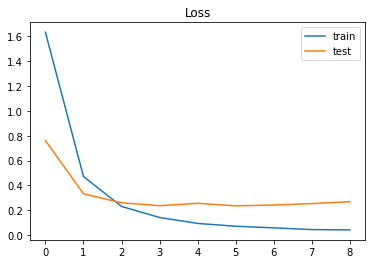

In [ ]:
plt.title('Loss'),
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label ='test')
plt.legend()
plt.show();

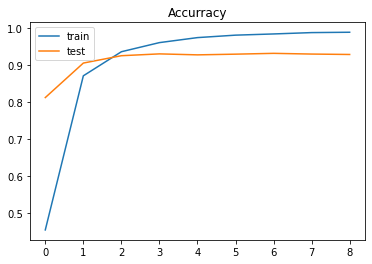

In [ ]:
plt.title('Accurracy'),
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label ='test')
plt.legend()
plt.show();

In [ ]:
class_lable= list(category_label.keys())

In [ ]:
class_lable

['beauty', 'grocery', 'phone', 'music', 'office', 'lawn', 'toy', 'pet']

In [ ]:
cm=confusion_matrix(rounded_pred,y_test)

In [ ]:
fig= plt.figure(figsize=(10,10))
axes= sns.heatmap(cm,annot=True,square=True,fmt='d',cbar=True,cmap=plt.cm.OrRd)
axes.set_title("Confusion Matrix", fontsize=20,fontweight='bold',color='Red')
plt.xlabel("Actual",fontweight='bold',fontsize=15)
plt.ylabel("Model_prediction",fontweight='bold',fontsize=15)
axes.set_xticklabels(class_lable)
axes.set_yticklabels(class_lable)
plt.show()

#### Testing the model with test data

In [ ]:
txt={'''I dont know the flavor I haven't tasted it, but my indian puppy goes berserk even by its smell.
Its good stuff I can tell from my dogs reaction.
Dont just order it and start feeding it to your dog fullon, follow the introduction protocol for healthier outcomes.
And try to soak the kibble in mild warm (not hot for god sake) water for 20 min.
Your dog needs hydration more than that kibble.
So the water that is left after soaking helps hydrating pup. You can make a mixture of (50%warm water +25% kibble(let it soak 20 min) add 25% normal water so that water temp. is optimum even if you dont add last 25% your pooch will still finish it all(measurements are rogue you make your own adjustments accordingly'''}
seq= tokenizer.texts_to_sequences(txt)
padded= pad_sequences(seq,maxlen=max_length,truncating='post',padding='post')
pred=model.predict(padded)




In [ ]:
class_lable

['beauty', 'grocery', 'phone', 'music', 'office', 'lawn', 'toy', 'pet']

In [ ]:
print(pred,class_lable[np.argmax(pred)])

[[1.02142862e-04 1.69442256e-03 5.82555003e-05 3.18790626e-05
  3.33102507e-05 1.01184865e-04 4.58981449e-05 9.97932911e-01]] pet
